In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import itertools # 迭代器工具

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd # 数据分析
import seaborn as sns # 数据可视化

from sklearn.model_selection import train_test_split # 数据集划分
from sklearn.metrics import confusion_matrix # 混淆矩阵

from tensorflow.keras.models import Sequential # 顺序模型
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D # CNN层
from tensorflow.keras.optimizers import RMSprop # 均方根优化算法
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 图像扩增
from tensorflow.keras.callbacks import ReduceLROnPlateau # 学习停滞时减小学习率

np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

In [2]:
# 数据整理

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1) # 丢弃标签
del train # 释放空间

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

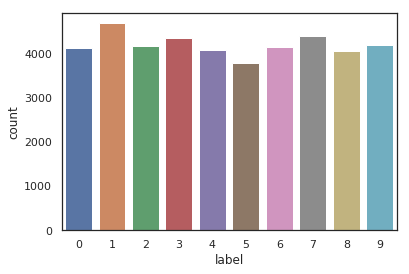

In [3]:
#  可视化

g = sns.countplot(Y_train) # 各标签数量可视化
Y_train.value_counts() # 各标签数量

In [4]:
# 数据检查

X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
# 归一化

X_train = X_train / 255.0
test = test / 255.0

In [7]:
# 重塑大小

X_train = X_train.values.reshape(-1, 28, 28, 1) # 28*28*1
test = test.values.reshape(-1, 28, 28, 1)

In [8]:
# one-hot标签

Y_train = keras.utils.to_categorical(Y_train, num_classes=10)

In [9]:
# 划分交叉验证集

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)
# test_size: 浮点数则表示占比，整数则表示样本数 random_state: 随机数种子

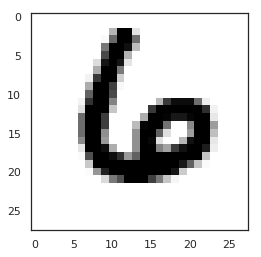

In [10]:
# 可视化训练样本

g = plt.imshow(X_train[1024][:, :, 0], cmap=plt.cm.gray_r)

In [11]:
# 建立CNN模型：
# 输入层 -> [卷积层*2(Conv2D) -> 池化层(MaxPool) -> 随机失活*2(Dropout)]*2 -> 展平(Flatten) -> 全连接(Dense) -> 随机失活(Dropout) -> 输出

model = Sequential() 
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1))) 
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.5,min_lr=0.00001)
epochs = 10
batch_size = 86

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, Y_val), verbose=2, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
4200/4200 [==============================] - 1s 153us/sample - loss: 0.0570 - acc: 0.9833
 - 16s - loss: 0.4445 - acc: 0.8584 - val_loss: 0.0569 - val_acc: 0.9833
Epoch 2/10
4200/4200 [==============================] - 1s 122us/sample - loss: 0.0452 - acc: 0.9855
 - 14s - loss: 0.1392 - acc: 0.9591 - val_loss: 0.0451 - val_acc: 0.9855
Epoch 3/10
4200/4200 [==============================] - 0s 116us/sample - loss: 0.0326 - acc: 0.9895
 - 14s - loss: 0.1035 - acc: 0.9702 - val_loss: 0.0326 - val_acc: 0.9895
Epoch 4/10
4200/4200 [==============================] - 1s 122us/sample - loss: 0.0352 - acc: 0.9902
 - 14s - loss: 0.0818 - acc: 0.9762 - val_loss: 0.0352 - val_acc: 0.9902
Epoch 5/10
4200/4200 [==============================] - 1s 121us/sample - loss: 0.0305 - acc: 0.9926
 - 14s - loss: 0.0792 - acc: 0.9769 - val_loss: 0.0305 - val_acc: 0.9926
Epoch 6/10
4200/4200 [==============================] - 1s 122us/sample - loss: 0.

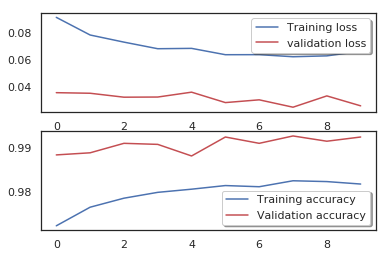

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [21]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)